In [2]:
import cv2
import numpy as np
import os

In [125]:
image_dir = "Test_Dataset/Unstable/Before"
mask_dir = "Test_Dataset/UnstableMotion"
before_image_dir = "Test_Dataset\Depth_Blender\Before"

annotations = {}

for img_filename in os.listdir(image_dir):
    mask_filename = img_filename.replace("before", "after")  # Ensure correct mapping
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if os.path.exists(mask_path):
        boxes = extract_bounding_boxes(mask_path)
        if boxes:
            annotations[img_filename] = boxes


<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ajeet\AppData\Local\Temp\ipykernel_3952\3601651216.py:3: SyntaxWarning: invalid escape sequence '\D'
  before_image_dir = "Test_Dataset\Depth_Blender\Before"


In [2]:
import cv2
import matplotlib.pyplot as plt

def extract_bounding_boxes(mask_path):
  
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 3000: 
            bounding_boxes.append([x, y, x + w, y + h])

    return bounding_boxes

def visualize_one_image(image_path, mask_path):
   
    boxes = extract_bounding_boxes(mask_path)
    
    if boxes:
 
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
        
        for box in boxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red color for boxes
        

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off') 
        plt.show()
    else:
        print("No bounding boxes found in the mask.")

image_dir = "Test_Dataset/Unstable/Before"
mask_dir = "Test_Dataset/UnstableMotion"
before_image_dir = "Test_Dataset/Depth_Blender/Before"

annotations = {}

for img_filename in os.listdir(image_dir):
    mask_filename = img_filename.replace("before", "after")  
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if os.path.exists(mask_path):
        boxes = extract_bounding_boxes(mask_path)
        if boxes: 
            annotations[img_filename] = boxes


image_path = "Test_Dataset/Depth_Blender/Before/render_782_before.png"
mask_path = "Test_Dataset/UnstableMotion/render_782_after.png" 

visualize_one_image(image_path, mask_path)


NameError: name 'os' is not defined

In [233]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image

class UnstableDataset(Dataset):
    def __init__(self, before_image_dir, annotations):
        self.image_dir = before_image_dir
        self.annotations = annotations 
        self.image_files = list(annotations.keys())
        self.transform = T.ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        boxes = torch.tensor(self.annotations[self.image_files[idx]], dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) 

        target = {"boxes": boxes, "labels": labels}
        return img, target


In [235]:
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

dataset = UnstableDataset(before_image_dir, annotations)
train_dl = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 15

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, targets in train_dl:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with autocast():  # Enable mixed precision
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "faster_rcnn_unstable.pth")


C:\Users\ajeet\AppData\Local\Temp\ipykernel_3952\3908649062.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ajeet\AppData\Local\Temp\ipykernel_3952\3908649062.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Epoch 1, Loss: 43.1614
Epoch 2, Loss: 31.1777
Epoch 3, Loss: 27.7790
Epoch 4, Loss: 24.6608
Epoch 5, Loss: 23.1805
Epoch 6, Loss: 21.4764
Epoch 7, Loss: 19.9797
Epoch 8, Loss: 17.6420
Epoch 9, Loss: 17.3990
Epoch 10, Loss: 16.2924
Epoch 11, Loss: 14.1047
Epoch 12, Loss: 14.0245
Epoch 13, Loss: 12.5179
Epoch 14, Loss: 13.3861
Epoch 15, Loss: 12.0060


C:\Users\ajeet\AppData\Local\Temp\ipykernel_34048\3605931353.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/Faster_RCNN/

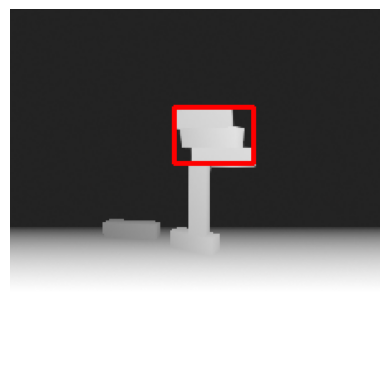

In [73]:
import torchvision
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load("saved_models/Faster_RCNN/TEST2_faster_rcnn_unstable.pth", map_location=device))
model.to(device)
model.eval()

def predict_and_visualize_with_nms(model, image_path, threshold, iou_threshold=0.3):
    
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(img_tensor)

    pred_boxes = torch.tensor(predictions[0]["boxes"].cpu().numpy(), dtype=torch.float32)
    pred_scores = torch.tensor(predictions[0]["scores"].cpu().numpy(), dtype=torch.float32)

    keep = torchvision.ops.nms(pred_boxes, pred_scores, iou_threshold)


    pred_boxes = pred_boxes[keep].numpy()
    pred_scores = pred_scores[keep].numpy()

    img_cv = cv2.imread(image_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    for box, score in zip(pred_boxes, pred_scores):
        if score > threshold:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img_cv)
    plt.axis("off")
    plt.show()

predict_and_visualize_with_nms(model, "DEPTH_COMBINED DATASET2/test/Unstable/6B-3D-Non-Rot_SPLIT_render_409_persp_left.png", threshold=0.6, iou_threshold=0.3)
